# Test der Netzqualität mittels der Trainingsbilder

Das im ersten Teil erzeugte und gespeicherte Netz wird hier getestet:

0. Vorbereitung (Laden der Bibliotheken und Einstellungen)
1. Laden des neuronalen Netzes
2. Test anhand der Trainingsdaten

### 0) Vorbereitung

##### Modelname
ACHTUNG: hier muss der korrekte Modelname definiert werden, wie er auch im letzten Skript verwendet wurde.

##### Bibliotheken
Laden der notwendigen Bibliotheken.

In [1]:
###############################################################################

ModelNameAndVersion = "dig-s0-q"

###############################################################################

import tensorflow.python.keras as keras
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image 
import numpy as np
import pandas as pd
import tensorflow as tf
import tflite_runtime.interpreter as tflite

2022-02-13 19:10:02.394414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 19:10:02.394488: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1) Laden des neuronalen Netzes

Mittels der Funktion "load_model" wird das Model geladen und anschließend die Architektur im Überblick nochmals ausgegeben.

In [2]:

# Load quantized TFLite model
tflite_interpreter_quant = tflite.Interpreter(model_path='a_output_actual/' + ModelNameAndVersion + '.tflite')
tflite_interpreter_quant.allocate_tensors()

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
#tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
#tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
#tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])




#model = keras.models.load_model('a_output_actual/' + ModelNameAndVersion)

#model.summary()

== Input details ==
name: serving_default_batch_normalization_input:0
shape: [ 1 32 20  3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 11]
type: <class 'numpy.float32'>


In [3]:
Input_Raw = 'ziffer_problems_raw'
Output_Resize= 'ziffer_problems_resize'

target_size_x = 20
target_size_y = 32

Input_dir = 'ziffer_problems_resize'

#resize.empty_directory(Output_Resize)

files = glob.glob(Output_Resize + '/*.jpg')
i = 0
for f in files:
    os.remove(f)
    i=i+1
print(str(i) + ' files have been deleted.')


#resize.image_resize(Input_Raw, Output_Resize, target_size_x, target_size_y)

files = glob.glob(Input_Raw + '/*.jpg')
i = 0
for aktfile in files:
#    print(aktfile)
    test_image = Image.open(aktfile)
    test_image = test_image.resize((target_size_x, target_size_y), Image.NEAREST)
    base=os.path.basename(aktfile)
    save_name = Output_Resize + '/' + base
    test_image.save(save_name, 'JPEG')
    i=i+1
print(str(i) + ' files have been added.')



21 files have been deleted.
21 files have been added.


### 2) Test anhand der Trainingsdaten

Einen guten Eindruck über die Qualität liefert eine Iteration über alle Trainingsbilder. Dazu wird jedes Bild (ACHTUNG: schon in der Zielauflösung) einzeln geladen und durch das neuronale Netz berechnet. SOLL- und IST-Werte werden zum einen in einem Array gespeichert. 

Wenn diese nicht identisch sind, werden die entsprechenden Bilder und die zugehörigen Daten direkt ausgegeben. Das hilft sehr bei der Fehlersuche, denn häufige hat man noch einen Fehler in der Klassifizierung oder erkennt, dass das Bild doch so schlecht ist, dass es besser nicht verwendet werden sollte.

In [4]:
res = []

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    Dateiname      = os.path.basename(aktfile)    # Dateiname
    Classification_SOLL = Dateiname[0:1]          # Die erste Ziffer entspricht der Zugehörigen Klassifizierung
    if Classification_SOLL == "N":
        Classification_SOLL = 10                  # NaN does not work --> convert to 10
    else:
        Classification_SOLL = int(Classification_SOLL)

    image_in = Image.open(aktfile)
    data = np.array(image_in)
    img = np.reshape(data,[1,32,20,3])
    img = img.astype(np.float32) 
    
    test_image = Image.open(aktfile)
test_image = test_image.resize((20, 32), Image.NEAREST)
test_image = np.array(test_image, dtype="float32")
img = np.reshape(test_image,[1,32,20,3])
    
    tflite_interpreter_quant.set_tensor(input_details[0]['index'], img)
    tflite_interpreter_quant.invoke()
    tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])

#    tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
#    tflite_q_pred_dataframe.columns = dataset_labels

#    print("Quantized TFLite model prediction results for the first elements")
#    tflite_q_pred_dataframe.head()
    
    print(tflite_q_model_predictions)
    
    Classification_IST = np.argmax(tflite_q_model_predictions)
#    Classification_IST = classes[0]
    
    res.append(np.array([Classification_SOLL, Classification_IST]))
    
#    if Classification_SOLL != Classification_IST:
#        print("Falsche Erkennung: " + aktfile + " Soll: " + str(Classification_SOLL) +  " IST: " + str(Classification_IST))
#        display(image_in)

res = np.asarray(res)


[[0.99609375 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.99609375 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.99609375 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.        0.3359375 0.        0.        0.        0.        0.
  0.        0.        0.        0.6640625]]
[[0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.         0.99609375 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.         0.99609375 0.         0.         0.         0

#### Visualisierung über die gesamten Trainingsbilder

Im vorherigen Schritt wurde für jedes Bild sowohl Soll, wie auch IST-Wert gespeichert. Hier wird über die einzelnen Bilder beide Werte in einem Diagramm dargestellt.

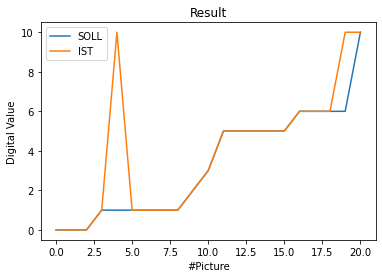

In [5]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['SOLL','IST'], loc='upper left')
plt.show()